In [160]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from patsy import dmatrices
import warnings
warnings.filterwarnings('ignore')

In [161]:
df= pd.read_csv('Output_files/Data_pre.csv')

In [162]:
df.tail()

,property,state,sqft,age,claims,exposure,freq,age_bins
8204,8408,OH,65374,39,18,65.374,0.275339,40
8205,8409,AZ,84879,45,2,84.879,0.023563,50
8206,8410,AZ,65986,25,8,65.986,0.121238,30
8207,8411,OH,16746,85,22,16.746,1.313747,90
8208,8412,AZ,24166,47,8,24.166,0.331044,50


In [176]:
df["state"].value_counts()

AZ    4895
FL    2489
OH     825
Name: state, dtype: int64

Transforming the state into numerical values using dummies lib 

In [163]:
transformed=pd.get_dummies(df['state'],drop_first=True)
df=pd.concat((df,transformed),axis=1)

Training only on 60% of the data and then modelling using GL stat package

In [165]:
mask = np.random.rand(len(df)) < 0.6
df_train = df[mask]
df_test = df[~mask]

In [166]:
expr = 'freq ~FL+OH+age_bins'
#Let’s use Patsy to carve out the X and y matrices for the training and testing data sets:

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [167]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   freq   No. Observations:                 4854
Model:                            GLM   Df Residuals:                     4850
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3038.5
Date:                Tue, 02 Nov 2021   Deviance:                       1981.8
Time:                        14:12:35   Pearson chi2:                 4.79e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0308      0.072    -28.246      0.0

we can view the coefficients and P values for each feature 
1) Got Devinace (1981.8) and log-likelihood (-3038.5)


Below verify the stnadard erorr and Confidence interval 

In [168]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
#summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

          mean   mean_se  mean_ci_lower  mean_ci_upper
2     0.205397  0.013736       0.180165       0.234164
4     0.221783  0.008872       0.205058       0.239873
6     0.179791  0.008954       0.163071       0.198226
7     0.303857  0.012342       0.280605       0.329035
9     0.303857  0.012342       0.280605       0.329035
...        ...       ...            ...            ...
8203  0.199686  0.008816       0.183134       0.217734
8205  0.221783  0.008872       0.205058       0.239873
8206  0.179791  0.008954       0.163071       0.198226
8207  0.540515  0.041785       0.464520       0.628943
8208  0.221783  0.008872       0.205058       0.239873

[3355 rows x 4 columns]


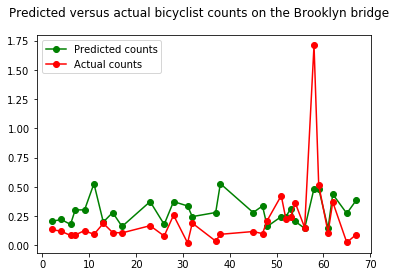

In [179]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['freq']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index[:30], predicted_counts[:30], 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index[:30], actual_counts[:30], 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [171]:
df_train, df_test = train_test_split(df, test_size=0.33, random_state=0)

In [172]:
from sklearn.linear_model import PoissonRegressor
preprocessor = ColumnTransformer(
    [
        ("numeric", "passthrough", ['FL','OH','age_bins']),
    ],
    remainder="drop",
)
n_samples = df_train.shape[0]

poisson_glm = Pipeline(
    [     ("preprocessor", preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)
poisson_glm.fit(
    df_train, df_train["freq"], regressor__sample_weight=df_train["exposure"]
)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', 'passthrough',
                                                  ['FL', 'OH', 'age_bins'])])),
                ('regressor', PoissonRegressor(alpha=1e-12, max_iter=300))])

In [173]:
from sklearn.metrics import mean_poisson_deviance
mask = y_pred > 0
y_pred = poisson_glm.predict(df_test)
print(mean_poisson_deviance(
            df_test["freq"][mask],
            y_pred[mask],
            sample_weight=df_test["exposure"][mask]))

0.09951779819128566


Actual number of claims: 20598
Predicted number of claims by PoissonRegressor(alpha=1e-12, max_iter=300): 20647.1


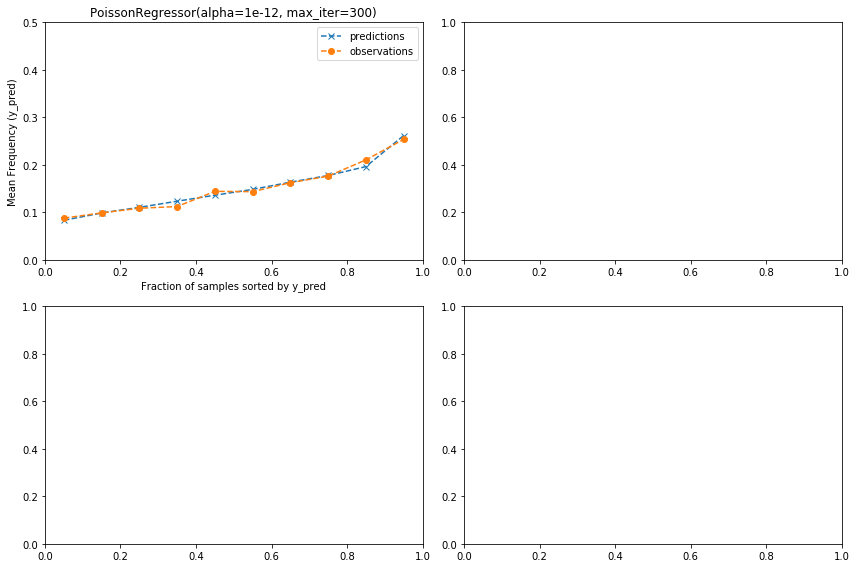

In [174]:
from sklearn.utils import gen_even_slices


def _mean_frequency_by_risk_group(y_true, y_pred, sample_weight=None, n_bins=100):
    """Compare predictions and observations for bins ordered by y_pred.

    We order the samples by ``y_pred`` and split it in bins.
    In each bin the observed mean is compared with the predicted mean.

    Parameters
    ----------
    y_true: array-like of shape (n_samples,)
        Ground truth (correct) target values.
    y_pred: array-like of shape (n_samples,)
        Estimated target values.
    sample_weight : array-like of shape (n_samples,)
        Sample weights.
    n_bins: int
        Number of bins to use.

    Returns
    -------
    bin_centers: ndarray of shape (n_bins,)
        bin centers
    y_true_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    y_pred_bin: ndarray of shape (n_bins,)
        average y_pred for each bin
    """
    idx_sort = np.argsort(y_pred)
    bin_centers = np.arange(0, 1, 1 / n_bins) + 0.5 / n_bins
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)

    for n, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        weights = sample_weight[idx_sort][sl]
        y_pred_bin[n] = np.average(y_pred[idx_sort][sl], weights=weights)
        y_true_bin[n] = np.average(y_true[idx_sort][sl], weights=weights)
    return bin_centers, y_true_bin, y_pred_bin


print(f"Actual number of claims: {df_test['claims'].sum()}")
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3)

for axi, model in zip(ax.ravel(), [poisson_glm]):
    y_pred = model.predict(df_test)
    y_true = df_test["freq"].values
    exposure = df_test["exposure"].values
    q, y_true_seg, y_pred_seg = _mean_frequency_by_risk_group(
        y_true, y_pred, sample_weight=exposure, n_bins=10
    )

    # Name of the model after the estimator used in the last step of the
    # pipeline.
    print(f"Predicted number of claims by {model[-1]}: {np.sum(y_pred * exposure):.1f}")

    axi.plot(q, y_pred_seg, marker="x", linestyle="--", label="predictions")
    axi.plot(q, y_true_seg, marker="o", linestyle="--", label="observations")
    axi.set_xlim(0, 1.0)
    axi.set_ylim(0, 0.5)
    axi.set(
        title=model[-1],
        xlabel="Fraction of samples sorted by y_pred",
        ylabel="Mean Frequency (y_pred)",
    )
    axi.legend()
plt.tight_layout()